# Model 2: with undersampling and feature selection

In [5]:
# import libraries
import pandas as pd
import numpy as np 
import random
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
#import data 
dfall = pd.read_csv('CreditCardFraud_AllData.csv')
df3 = pd.read_csv('CreditCardFraud_3.csv')

In [3]:
# Need to transform the data in the columns Time and Amount to go with the rest
std_scaler = StandardScaler()

dfall['scaled_amount'] = std_scaler.fit_transform(dfall['Amount'].values.reshape(-1,1))
dfall['scaled_time'] = std_scaler.fit_transform(dfall['Time'].values.reshape(-1,1))
dfall.drop(['Time','Amount'], axis=1, inplace=True)

df3['scaled_amount'] = std_scaler.fit_transform(df3['Amount'].values.reshape(-1,1))
df3['scaled_time'] = std_scaler.fit_transform(df3['Time'].values.reshape(-1,1))
df3.drop(['Time','Amount'], axis=1, inplace=True)

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [6]:
random.seed(20)

#Create an undersampled version of the dataset to use to build the model
X_all = df3.iloc[:, df3.columns != 'Is.Fraud']
y_all = df3.iloc[:, df3.columns == 'Is.Fraud']

# Count number of data points in the minority class
fraud_count = len(df3[df3['Is.Fraud'] == 1])

# Create separate arrays for the different cases (fraud / not fraud)
fraud_trans = np.array(df3[df3['Is.Fraud'] == 1].index)
normal_trans = df3[df3['Is.Fraud'] == 0].index

# Out of the normal transactions, select "fraud_count" number of transactions randomly
random_normal_trans = np.random.choice(normal_trans, fraud_count, replace = False)
random_normal_trans = np.array(random_normal_trans)

# Combining the normal and fraud transaction
under_sample_trans = np.concatenate([fraud_trans,random_normal_trans])

# Create the undersampled dataset
under_sample_data = df3.iloc[under_sample_trans,:]

X_undersample = under_sample_data.iloc[:, under_sample_data.columns != 'Is.Fraud']
y_undersample = under_sample_data.iloc[:, under_sample_data.columns == 'Is.Fraud']

# Print result
print("Proportion of non-fraud transactions: ", len(under_sample_data[under_sample_data['Is.Fraud'] == 0])/len(under_sample_data))
print("Proportion of fraud transactions: ", len(under_sample_data[under_sample_data['Is.Fraud'] == 1])/len(under_sample_data))
print("Total number of transactions in undersampled data: ", len(under_sample_data))

Proportion of non-fraud transactions:  0.5
Proportion of fraud transactions:  0.5
Total number of transactions in undersampled data:  984


In [7]:
from sklearn.utils import shuffle

#shuffle data
under_sample_data = shuffle(under_sample_data)
print(under_sample_data.head())

      Is.Fraud        V1        V2        V3        V4        V5        V6  \
3727     False -0.175798  0.158391  0.879935 -0.914384  0.187858 -0.083381   
2765     False  2.052474 -1.040446  0.378339 -0.187582 -1.693043 -0.246380   
4797      True  1.954852  1.630056 -4.337200  2.378367  2.113348 -1.583851   
4866      True -5.961457  5.313382 -6.674320  6.028975 -1.387560  0.670638   
3823     False -0.125908  0.510725 -1.014394 -0.580112  2.966624  3.949108   

            V7        V8        V9     ...            V21       V22       V23  \
3727  0.284882  0.083052  0.748820     ...       0.342443  1.063350  0.055491   
2765 -1.470745  0.070844  0.679577     ...      -0.117307  0.368662  0.268465   
4797  0.653745 -0.192892  1.217608     ...      -0.474437 -0.974625 -0.048155   
4866 -4.128987 -4.765894 -1.005259     ...       5.556642 -1.501808  1.355172   
3823  0.094789  1.036705  0.308453     ...      -0.299125 -0.590162 -0.018374   

           V24       V25       V26       V27

True     492
False    492
Name: Is.Fraud, dtype: int64


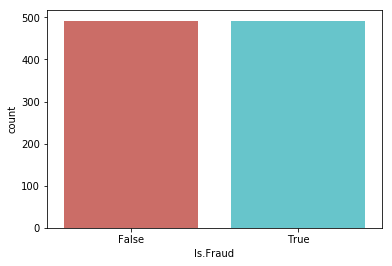

In [8]:
#count how many are of each class in the undersampled dataframe: Fraud or not fraud
fraud_class = under_sample_data['Is.Fraud'].value_counts()
print(fraud_class)
sns.countplot(x='Is.Fraud',data=under_sample_data, palette='hls')

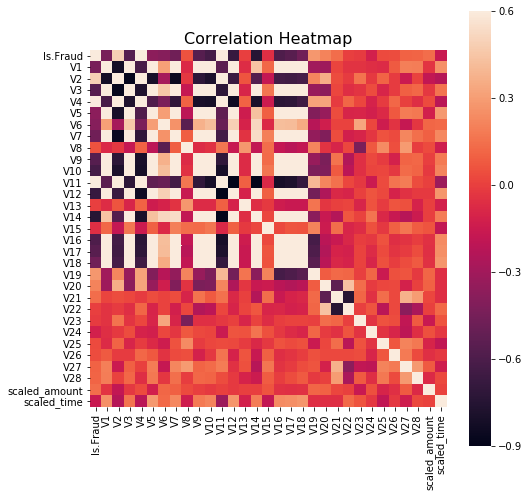

In [9]:
correlation = under_sample_data.corr()
f , ax = plt.subplots(figsize = (8,8)) 
plt.title('Correlation Heatmap',y=1,size=16) 
sns.heatmap(correlation, square = True, vmax=0.6)

In [10]:
#want to find the features which have the strongest correlation with fraud
correlation = under_sample_data.corr()['Is.Fraud'][1:]

#Make a list of the features which have a correlation with absolute value larger than 0.5 to list out
features_list = correlation[abs(correlation) > 0.5].sort_values(ascending=False)
print("There is {} values which are notably correlated with Is.Fraud:\n{}".format(len(features_list), features_list))

There is 9 values which are notably correlated with Is.Fraud:
V4     0.719076
V11    0.686346
V17   -0.560902
V3    -0.561829
V9    -0.563798
V16   -0.592647
V10   -0.626877
V12   -0.682708
V14   -0.746828
Name: Is.Fraud, dtype: float64


In [11]:
# Choose the columns we want to use to predict fraud with using correlation
names = ['Is.Fraud','V3', 'V4','V9', 'V10','V11', 'V12', 'V14','V16','V17']
train_cols = names[1:]

# Use the logit function as we are doing logistic regression
logit = sm.Logit(under_sample_data['Is.Fraud'], under_sample_data[train_cols]) # We fit the model
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.390123
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:               Is.Fraud   No. Observations:                  984
Model:                          Logit   Df Residuals:                      975
Method:                           MLE   Df Model:                            8
Date:                Mon, 14 Jan 2019   Pseudo R-squ.:                  0.4372
Time:                        15:24:13   Log-Likelihood:                -383.88
converged:                       True   LL-Null:                       -682.06
                                        LLR p-value:                1.425e-123
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
V3            -0.0454      0.062     -0.729      0.466      -0.167       0.077
V4             0.3141      0

In [12]:
X3 = df3.iloc[:, df3.columns != 'Is.Fraud']
y3 = df3.iloc[:, df3.columns == 'Is.Fraud']

# Split subset 3 into test and train sets
X3_train, X3_test, y3_train, y3_test = train_test_split(df3[train_cols],df3['Is.Fraud'],test_size = 0.3, random_state = 0)

print("Transactions train dataset: ", len(X3_train))
print("Transactions test dataset: ", len(X3_test))
print("Total transactions: ", len(X3_train)+len(X3_test))


# Split undersampled dataset into test and train sets
X_train, X_test, y_train, y_test = train_test_split(under_sample_data[train_cols],under_sample_data['Is.Fraud'],test_size = 0.3, random_state = 0)

print("Transactions train dataset: ", len(X_train))
print("Transactions test dataset: ", len(X_test))
print("Total transactions: ", len(X_train)+len(X_test))

Transactions train dataset:  3500
Transactions test dataset:  1500
Total transactions:  5000
Transactions train dataset:  688
Transactions test dataset:  296
Total transactions:  984


In [116]:
print(df3[train_cols].head())
print(under_sample_data[train_cols].head())

         V3        V4        V9       V10       V11       V12       V14  \
0  0.924591 -0.727219 -0.665271 -0.737980  0.324098  0.277192 -0.291896   
1  1.146088  0.656290 -0.523849  0.690440  1.160793  0.831569 -0.018098   
2 -0.268073  0.125245 -0.230000  0.295110 -0.596572 -0.118181  0.063381   
3  1.230334  2.554474  0.307571  0.475235 -1.410625 -0.508594 -0.199105   
4  2.528964  0.648279  0.435493 -0.308060 -0.678178 -0.219642 -0.383811   

        V16       V17  
0  1.143174 -0.928709  
1 -0.180816 -0.749369  
2 -0.608157 -0.159370  
3  0.541796 -0.274024  
4 -0.471960  0.419925  
             V3        V4        V9        V10       V11        V12  \
4950  -5.799736  6.502330 -1.977238  -3.473411  4.569194  -9.321153   
667    0.152203  0.610806  0.073360  -0.279397 -0.406080   0.058996   
891    0.944741  0.169046 -0.775537  -1.125841  0.043177   0.617806   
2603  -0.141146 -1.035277 -0.967204  -0.220305  0.528163   0.318813   
4635 -13.770001  8.694897 -8.090697 -12.780634  5.

In [13]:
#we fit and predict a model on the undersampled data first
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.94


In [14]:
from sklearn.metrics import confusion_matrix
#Look at confusion matrix
confusionmatrix = confusion_matrix(y_test, y_pred)
print(confusionmatrix)

[[141   7]
 [ 11 137]]


Text(0.5,257.44,'Predicted label')

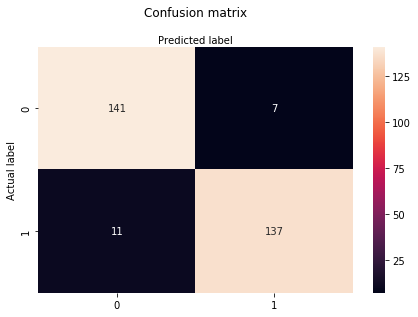

In [15]:
#Make presentable confusion matrix
classes=['False','True'] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
sns.heatmap(pd.DataFrame(confusionmatrix), annot=True ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [16]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      False       0.93      0.95      0.94       148
       True       0.95      0.93      0.94       148

avg / total       0.94      0.94      0.94       296



In [17]:
#try to predicting using the data from d3
y3_pred = logreg.predict(X3_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X3_test, y3_test)))

Accuracy of logistic regression classifier on test set: 0.95


In [18]:
from sklearn.metrics import confusion_matrix
#Look at confusion matrix
confusionmatrix = confusion_matrix(y3_test, y3_pred)
print(confusionmatrix)
print(classification_report(y3_test, y3_pred))

[[1297   54]
 [  15  134]]
             precision    recall  f1-score   support

      False       0.99      0.96      0.97      1351
       True       0.71      0.90      0.80       149

avg / total       0.96      0.95      0.96      1500



Text(0.5,257.44,'Predicted label')

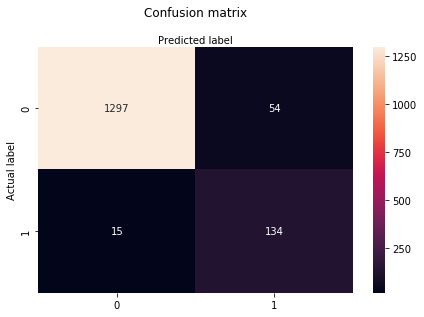

In [19]:
#Make presentable confusion matrix
classes=['False','True'] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
sns.heatmap(pd.DataFrame(confusionmatrix), annot=True ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Model 3: Feature selection methods

In [20]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Lasso, RandomizedLasso
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

feature_names = list(X_undersample.columns.values)

In [134]:
logreg = LogisticRegression()

#specify that we want 9 features to compare with our own selection above
rfe = RFE(logreg, 9)
rfe = rfe.fit(X_undersample, y_undersample.values.ravel())
print(rfe.support_)
print(rfe.ranking_)
print('Selected features: %s' % list(X_undersample.columns[rfe.support_]))

[False False False  True False False False  True False  True False  True
  True  True False  True  True False False False False False False False
 False False False  True False False]
[11 15 19  1  4 12 22  1  8  1  2  1  1  1 14  1  1 17 20  7 21  3 16 18
  9  6 13  1  5 10]
Selected features: ['V4', 'V8', 'V10', 'V12', 'V13', 'V14', 'V16', 'V17', 'V28']


C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


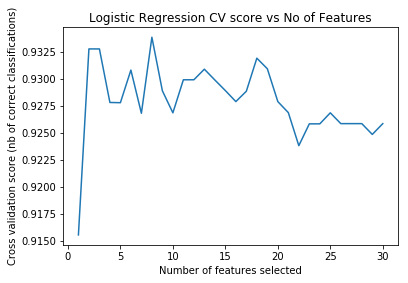

In [21]:
logreg_model = LogisticRegression()
strat_k_fold = StratifiedKFold(n_splits=10,random_state=42)
rfecv = RFECV(estimator=logreg_model, step=1, cv=strat_k_fold, scoring='accuracy')
rfecv.fit(X_undersample, y_undersample)

plt.figure()
plt.title('Logistic Regression CV score vs No of Features')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [22]:
print(rfecv.support_)
print('Selected features: %s' % list(X_undersample.columns[rfecv.support_]))

[False False False  True False False False  True False False False  True
 False  True False False False False False False  True False False False
 False False  True  True  True False]
Selected features: ['V4', 'V8', 'V12', 'V14', 'V21', 'V27', 'V28', 'scaled_amount']


In [23]:
names = ['Is.Fraud','V4', 'V8', 'V10', 'V12', 'V13', 'V14', 'V16', 'V17', 'V28']
train_cols3 = names[1:]

#We use the logit function as we are doing logistic regression
logit = sm.Logit(under_sample_data['Is.Fraud'], under_sample_data[train_cols3]) # We fit the model
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.387426
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:               Is.Fraud   No. Observations:                  984
Model:                          Logit   Df Residuals:                      975
Method:                           MLE   Df Model:                            8
Date:                Mon, 14 Jan 2019   Pseudo R-squ.:                  0.4411
Time:                        15:25:24   Log-Likelihood:                -381.23
converged:                       True   LL-Null:                       -682.06
                                        LLR p-value:                1.029e-124
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
V4             0.3118      0.064      4.893      0.000       0.187       0.437
V8            -0.1695      0

In [24]:
# Split subset 3 into test and train sets
X3_train, X3_test, y3_train, y3_test = train_test_split(df3[train_cols3],df3['Is.Fraud'],test_size = 0.3, random_state = 0)

print("Transactions train dataset: ", len(X3_train))
print("Transactions test dataset: ", len(X3_test))
print("Total transactions: ", len(X3_train)+len(X3_test))


# Split undersampled dataset into test and train sets
X_train, X_test, y_train, y_test = train_test_split(under_sample_data[train_cols3],under_sample_data['Is.Fraud'],test_size = 0.3, random_state = 0)

print("Transactions train dataset: ", len(X_train))
print("Transactions test dataset: ", len(X_test))
print("Total transactions: ", len(X_train)+len(X_test))

Transactions train dataset:  3500
Transactions test dataset:  1500
Total transactions:  5000
Transactions train dataset:  688
Transactions test dataset:  296
Total transactions:  984


In [25]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.95


In [26]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[143   5]
 [ 11 137]]


In [140]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      False       0.92      0.96      0.94       160
       True       0.95      0.90      0.92       136

avg / total       0.93      0.93      0.93       296



In [27]:
#try to predicting using the data from d3
y3_pred = logreg.predict(X3_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X3_test, y3_test)))

Accuracy of logistic regression classifier on test set: 0.96


In [28]:
from sklearn.metrics import confusion_matrix
#Look at confusion matrix
confusionmatrix = confusion_matrix(y3_test, y3_pred)
print(confusionmatrix)
print(classification_report(y3_test, y3_pred))

[[1304   47]
 [  13  136]]
             precision    recall  f1-score   support

      False       0.99      0.97      0.98      1351
       True       0.74      0.91      0.82       149

avg / total       0.97      0.96      0.96      1500



Text(0.5,257.44,'Predicted label')

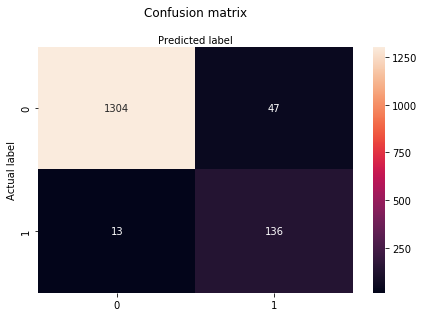

In [29]:
#Make presentable confusion matrix
classes=['False','True'] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
sns.heatmap(pd.DataFrame(confusionmatrix), annot=True ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Sources

 - https://towardsdatascience.com/machine-learning-workflow-on-diabetes-data-part-02-11262b7f7a5c